# Going Back to Work

## Part 1 Preprocessing

For the first part of this project, we will generate the demand model before the intervention by the decision making process. The following is what we do to get the predict model:

- We will be using the first 6 months of data from 2015 as our training dataset, and will be focusing on one place as our model input, which is 200 west street nyc
- We will generate 2 features from the dataset which are "weekday" and "hour" as our training input, to get the predicted number of drop offs at this location at each hour of a day
- The training algorithm that we use is Random Forest, we find that n_estimators=500 and max_leaf_nodes=70 will give us the best output
- We will give a graph showing the comparison between real number of drop offs and our predicted number of drop offs

In [1]:
import calendar
from calendar import * 
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Load datasets (the first 6 months of data from 2015)

In [2]:
records1 = pd.read_csv('./data/yellow_tripdata_2015-01.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])
records2 = pd.read_csv('./data/yellow_tripdata_2015-02.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])
records3 = pd.read_csv('./data/yellow_tripdata_2015-03.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])
records4 = pd.read_csv('./data/yellow_tripdata_2015-04.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])
records5 = pd.read_csv('./data/yellow_tripdata_2015-05.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])
records6 = pd.read_csv('./data/yellow_tripdata_2015-06.csv',usecols=["tpep_dropoff_datetime", "dropoff_latitude", "dropoff_longitude"])

Connect all the data together for future processing

In [3]:
records = pd.concat([records1, records2, records3, records4, records5, records6])
records.shape
records.head()

,tpep_dropoff_datetime,dropoff_longitude,dropoff_latitude
0,2015-01-15 19:23:42,-73.974785,40.750618
1,2015-01-10 20:53:28,-73.994415,40.759109
2,2015-01-10 20:43:41,-73.951820,40.824413
3,2015-01-10 20:35:31,-74.004326,40.719986
4,2015-01-10 20:52:58,-74.004181,40.742653


### Locate target place

We use geocoder to translate longitude and latitude to our target location, which is 200 west street nyc, and we will focus on its drop off numbers at each hour through out the day

In [4]:
# geo locator agent
geolocator = Nominatim(user_agent = "going_back_to_work")

# global variables
query_addr = "200 west street nyc"
target_location = geolocator.geocode(query_addr)
target_location

Location(Goldman Sachs Tower, West Street, Battery Park City, Manhattan, Manhattan Community Board 1, New York County, New York, 10282, United States of America, (40.7147553, -74.01441859133114, 0.0))

Limit the range to our target location

In [5]:
target_box = list(map(float, target_location.raw["boundingbox"]))
start_lat = min(target_box[0], target_box[1])
end_lat = max(target_box[0], target_box[1])
start_lng = min(target_box[2], target_box[3])
end_lng = max(target_box[2], target_box[3])

In [6]:
records = pd.DataFrame(records)
records = records[records["dropoff_latitude"] <= end_lat]
records = records[records["dropoff_latitude"] >= start_lat]
records = records[records["dropoff_longitude"] <= end_lng]
records = records[records["dropoff_longitude"] >= start_lng]
records.head

<bound method NDFrame.head of          tpep_dropoff_datetime  dropoff_longitude  dropoff_latitude
1788       2015-01-21 07:58:31         -74.014610         40.714119
6142       2015-01-30 08:34:16         -74.014381         40.714977
7079       2015-01-08 07:46:45         -74.014008         40.714279
16264      2015-01-29 10:02:13         -74.014450         40.714237
22659      2015-01-30 10:11:11         -74.014366         40.714153
...                        ...                ...               ...
12275356   2015-06-30 21:18:22         -74.014671         40.714642
12276318   2015-06-30 21:22:00         -74.014542         40.714241
12278887   2015-06-30 22:00:25         -74.014732         40.714413
12279480   2015-06-30 21:42:26         -74.014755         40.714199
12280460   2015-06-30 21:31:54         -74.014587         40.715096

[29134 rows x 3 columns]>

### Generate training and testing dataset

We will calculate weekday of each record, split one day into 24 hours, the output of our model will be the number of drop offs at each hour

In [7]:
datatime = records.values
print(datatime.shape)
print(datatime)

(29134, 3)
[['2015-01-21 07:58:31' -74.01461029052734 40.71411895751953]
 ['2015-01-30 08:34:16' -74.01438140869139 40.7149772644043]
 ['2015-01-08 07:46:45' -74.01400756835938 40.71427917480469]
 ...
 ['2015-06-30 22:00:25' -74.01473236083984 40.71441268920898]
 ['2015-06-30 21:42:26' -74.01475524902342 40.7141990661621]
 ['2015-06-30 21:31:54' -74.01458740234375 40.71509552001953]]


Augmente the dataset with weekdays and hours

Sort the dataset with date first, and hour next, from small to large

In [8]:
# Augmente our dataset
datatime_expand = pd.DataFrame()

dates = []
weekdays = []
hours = []

for i in range(len(datatime)):
    date = datatime[i][0]
    y = date[0:4]
    m = date[5:7]
    d = date[8:10]
    w = datetime.date(int(y),int(m),int(d))
    weekday = w.weekday()
    hour = int(date[date.index(" ")+1:date.index(" ")+3])
    date = y + m + d
    dates.append(int(date))
    weekdays.append(int(weekday))
    hours.append(int(hour))

datatime_expand['date'] = dates
datatime_expand['weekday'] = weekdays
datatime_expand['hour'] = hours

datatime_expand = datatime_expand.sort_values(by=['date','hour'])
datatime_expand

,date,weekday,hour
87,20150101,3,0
2521,20150101,3,4
771,20150101,3,8
2197,20150101,3,8
199,20150101,3,10
...,...,...,...
29132,20150630,1,21
29133,20150630,1,21
29128,20150630,1,22
29131,20150630,1,22


### Train model and make prediction

We are using Random Forest as our training algorithm, we find that n_estimators=500 and max_leaf_nodes=70 will give us the best output

Training set will be the most of the dataset. For the testing set, we will focus on one particular day. We will get prediction from our model and compare it with the real data.

In [9]:
# Organize dataset by date and hour
train = pd.DataFrame()
train['weekday'] = datatime_expand.groupby(['date', 'hour'])['weekday'].min()
train['hour'] = datatime_expand.groupby(['date', 'hour'])['hour'].min()
train['count'] = datatime_expand.groupby(['date', 'hour'])['hour'].count()
train

weekday  hour  count
date     hour                      
20150101 0           3     0      1
         4           3     4      1
         8           3     8      2
         10          3    10      4
         11          3    11      4
...                ...   ...    ...
20150630 19          1    19      2
         20          1    20      1
         21          1    21      5
         22          1    22      2
20150701 15          2    15      1

[3221 rows x 3 columns]

In [10]:
# training set
start_x = train.shape[0] - 19
train= train.iloc[:start_x]

# testing set
weekday = [1] * 24
hour = [i for i in range(24)]
count = [0, 0, 0, 0, 0, 1, 7, 23, 30, 29, 18, 12, 9, 20, 7, 4, 11, 9, 4, 2, 1, 5, 2, 0]
test_t = {'weekday': weekday,
          'hour': hour,
          'count': count
         }
test = pd.DataFrame(test_t)

Use Random Forest from sklearn to get the model

In [11]:
rf_clf = RandomForestClassifier(n_estimators=500, 
                                max_leaf_nodes=70, 
                                random_state=666, 
                                oob_score=True, 
                                n_jobs=-1)

In [12]:
rf_clf.fit(train.drop('count', axis=1), train['count'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=70, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=666, verbose=0,
                       warm_start=False)

In [13]:
predict = rf_clf.predict(test.drop('count', axis=1))

### Comparison between real data and predicted data

From the graph we can see that, the model we get from Random Forest can make relatively precise prediction on the number of drop offs at a given location. But there is still some deviation from real data, and we think there are lots of factors that can cause the deviation:

- Obviously, every day is differnet
- Drop offs are subject to weather changes and season changes
- The dataset we use is not large enough, it only covers 6 months of one year, which means that each weekday will only appear ~24 times in our training set, which is really a small number
- There're holidays or activities from time to time, which can change people's routine

But we think using more data will definitly give us more precise pridiction

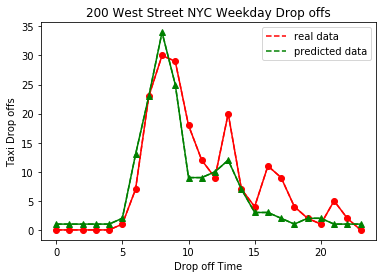

In [14]:
x_real = hour
y_real = count
x_predict = hour
y_predict = predict.tolist()

real_data = plt.plot(x_real, y_real, 'r--', label='real data')
predicted_data = plt.plot(x_predict, y_predict, 'g--', label='predicted data')
plt.plot(x_real, y_real, 'ro-', x_predict, y_predict, 'g^-')

plt.title('200 West Street NYC Weekday Drop offs')
plt.xlabel('Drop off Time')
plt.ylabel('Taxi Drop offs')
plt.legend()
plt.show()

## Part 2

For the second part of this project we are going to come up with an optimal decision policy which is used to limit the number of people showing up in the same location at the same time (we will use 1 hour time frame for the limitation). We will use the prediction model from part 1 as our input. By implementing our policy, we will get a more flattened curve than the predicted curve. Following are the main points of this part:

- What we already know
    - destination
    - arriving time
- The assumptions that we made to give the policy
    - The maximum capacity of the location is 15 people
    - one reservation appointment lasts 1 hour
- The policy will only accept (we allow for extending the appointment backward) or reject one appointment

### Preprocess dataset

For this part we only care about the time of arrival, and we also need to make sure the appointments arrive in chronological order

In [15]:
datatime_reserve = pd.DataFrame()
drop_off_time = []

for i in range(len(datatime)):
    date = datatime[i][0]
    reserve_date = date[0:10]
    if reserve_date == '2015-06-30':
        h = date[11:13]
        m = date[14:16]
        s = date[17:19]
        time = h + m + s
        drop_off_time.append(int(time))

drop_off_time.sort()

### Formulate policy

The general idea of the policy is that since the arriving time of appointments are in chronological order, we can extend their appointment backward when the location reaches its maximum capacity, until somebody leaves the location. We will reject the appointment if the it is extended to the next day, or the customer doesn't want to be extended, he / she can cancel the appointment by himself / herself.

In [16]:
# GLOBAL VARIABLE
MAX_CAPACITY = 15
IN_BUILDING = [0] * 15
COUNT = [0] * 24

for time in drop_off_time:
    if IN_BUILDING[0] == 0:
        IN_BUILDING[0] = time + 10000
        COUNT[time // 10000] += 1
        IN_BUILDING.sort()
    else:
        for i in range(15):
            if IN_BUILDING[i] > time:
                IN_BUILDING[0] += 10000
                COUNT[IN_BUILDING[0] // 10000 - 1] += 1
                IN_BUILDING.sort()
                break
        else:
            IN_BUILDING[0] = time + 10000
            COUNT[time // 10000] += 1
            IN_BUILDING.sort()

### Comparison between predicted data and flattened data

The graph below shows the predicted number of drop offs (which we get from part 1) and the number of drop offs after we implement the policy. We can see that our policy successfully flattened the curve while satisfied all of the appointment.

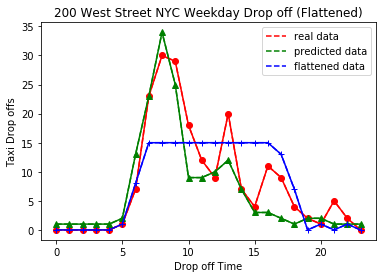

In [17]:
x_policy = hour
y_policy = COUNT

real_data = plt.plot(x_real, y_real, 'r--', label='real data')
predicted_data = plt.plot(x_predict, y_predict, 'g--', label='predicted data')
flattened_data = plt.plot(x_policy, y_policy, 'b--', label='flattened data')
plt.plot(x_real, y_real, 'ro-', x_predict, y_predict, 'g^-', x_policy, y_policy, 'b+-')

plt.title('200 West Street NYC Weekday Drop off (Flattened)')
plt.xlabel('Drop off Time')
plt.ylabel('Taxi Drop offs')
plt.legend()
plt.show()